In [2]:
import pickle
from caiman.base.rois import register_multisession
from caiman.utils import visualization
from caiman.source_extraction.cnmf.cnmf import load_CNMF
from pathlib import Path
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

2023-04-20 16:28:05.268800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Pairwise session tracking

In [9]:
data_path = Path("/ceph/imaging1/davide/2p_data/eq_luminance/")

# SESSION TO PREPROCESS
#sessions = {'441406_fiano':['20230301','20230306']}
sessions = {'441394_ribolla':['20230301','20230306']}


In [10]:
spatial = []
dims = []
templates = []
for animal in sessions.keys():
    for date in sessions[animal]:
        
        cnmf = load_CNMF(data_path.joinpath(f'{animal}/{date}/cnmf.hdf5'))
        with open(data_path.joinpath(f'{animal}/{date}/metrics.pickle'),'rb') as pfile:
            metrics = pickle.load(pfile)
        spatial.append(cnmf.estimates.A[:,cnmf.estimates.idx_components])
        dims.append(cnmf.dims)
        templates.append(np.asarray(metrics['corr_image']))


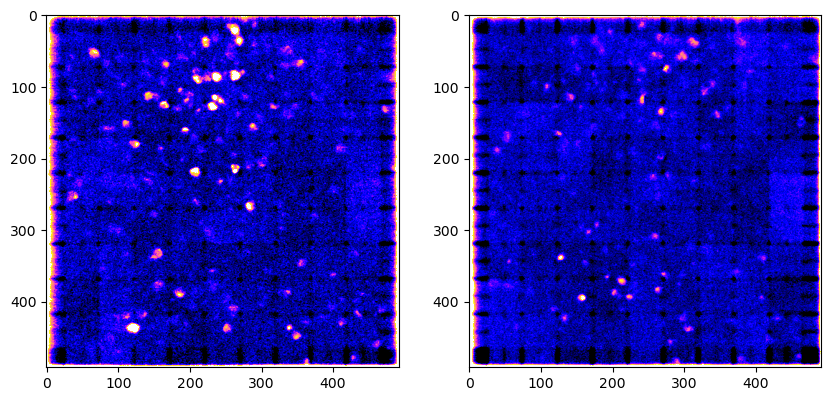

In [5]:
plt.figure(figsize=(10,5))
for i,t in enumerate(templates):
    plt.subplot(1,len(templates),i+1)
    plt.imshow(t,vmin=np.percentile(t.ravel(),3),vmax=np.percentile(t.ravel(),97),cmap=plt.cm.gnuplot2)

In [68]:
spatial_union, assignments, matchings = register_multisession(A=spatial, dims=dims[0], templates=templates)

/scratch/dspalla/mambaforge/envs/mescore/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [69]:
disjoint_union = spatial[0].shape[1]+spatial[1].shape[1]
n_matched = disjoint_union-spatial_union.shape[1]
max_matchable = min(spatial[0].shape[1],spatial[1].shape[1])
print(f'Disjoint union: {disjoint_union}')
print(f'Spatial union:{spatial_union.shape[1]}')
print(f'Number matched:{n_matched}')
print(f'Fraction matched: {n_matched/max_matchable}')

Disjoint union: 130
Spatial union:127
Number matched:3
Fraction matched: 0.057692307692307696


# Multiple session tracking

In [11]:
data_path = Path("/ceph/imaging1/davide/2p_data/eq_luminance/")
sessions = {'441406_fiano':['20230301','20230306','20230307','20230308','20230309','20230315','20230316','20230317','20230320','20230321'],
            '441394_ribolla':['20230301','20230306','20230307','20230308','20230309','20230315','20230316','20230317','20230320','20230321']
           }



In [28]:
spatial = []
dims = []
templates = []
animal = '441394_ribolla'
for date in sessions[animal]:

    cnmf = load_CNMF(data_path.joinpath(f'{animal}/{date}/cnmf.hdf5'))
    with open(data_path.joinpath(f'{animal}/{date}/metrics.pickle'),'rb') as pfile:
        metrics = pickle.load(pfile)
    spatial.append(cnmf.estimates.A[:,cnmf.estimates.idx_components])
    dims.append(cnmf.dims)
    templates.append(np.asarray(metrics['mean_image']))


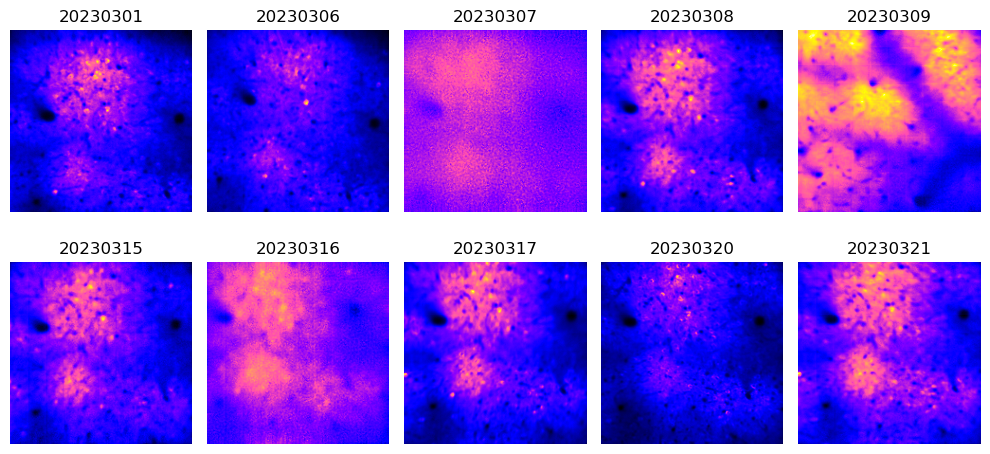

In [35]:
plt.figure(figsize=(10,5))
for i,t in enumerate(templates):
    plt.subplot(2,5,i+1)
    plt.title(f'{sessions[animal][i]}')
    plt.imshow(t,cmap=plt.cm.gnuplot2)
    plt.axis('off')
plt.tight_layout()
#plt.savefig(f'/ceph/imaging1/davide/2p_data/images/corr_imgs_{animal}.png')

In [31]:
spatial_union, assignments, matchings = register_multisession(A=spatial, dims=dims[0], templates=templates)

/scratch/dspalla/mambaforge/envs/mescore/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


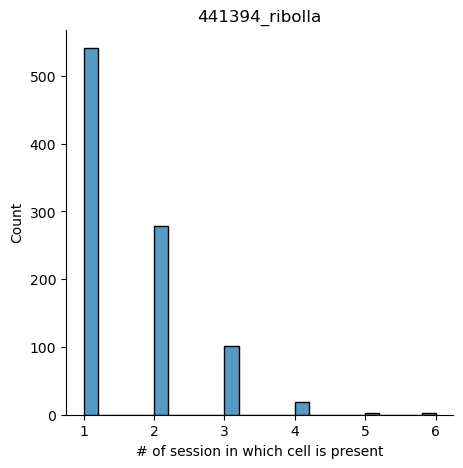

In [36]:
cell_frequency = np.sum(~np.isnan(assignments), axis=1)
plt.figure(figsize=(5,5))
plt.title(f'{animal}')
sns.histplot(cell_frequency)
plt.xlabel('# of session in which cell is present')
sns.despine()

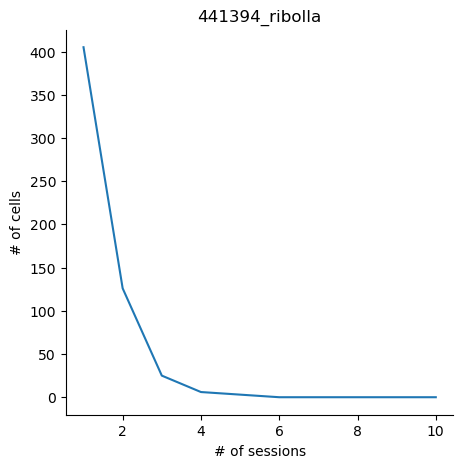

In [37]:
registered_cells = []
ns = np.arange(1,11)

for n in ns:
    registered_cells.append(np.sum(cell_frequency>n))

plt.figure(figsize=(5,5))
plt.title(f'{animal}')
plt.plot(ns,registered_cells)
plt.xlabel('# of sessions')
plt.ylabel('# of cells')
sns.despine()

# Pairwise matching distirbution

In [38]:
def compute_matched_fraction(session1,session2):
    
    cnmf1 = load_CNMF(f'{session1}/cnmf.hdf5')
    with open(f'{session1}/metrics.pickle','rb') as pfile:
            metrics1 = pickle.load(pfile)
            
    cnmf2 = load_CNMF(f'{session2}/cnmf.hdf5')
    with open(f'{session2}/metrics.pickle','rb') as pfile:
            metrics2 = pickle.load(pfile)
    
    
    
    A = [cnmf1.estimates.A[:,cnmf1.estimates.idx_components],cnmf2.estimates.A[:,cnmf2.estimates.idx_components]]
    dims = [cnmf1.dims,cnmf2.dims]
    templates = [np.asarray(metrics1['corr_image']),np.asarray(metrics2['corr_image'])]
    spatial_union, assignments, matchings = register_multisession(A=A, dims=dims[0], templates=templates)
    
    disjoint_union = A[0].shape[1]+A[1].shape[1]
    n_matched = disjoint_union-spatial_union.shape[1]
    max_matchable = min(A[0].shape[1],A[1].shape[1])
    
    
    return n_matched/max_matchable

In [39]:
data_path = Path("/ceph/imaging1/davide/2p_data/eq_luminance/")
sessions = {'441406_fiano':['20230301','20230306','20230307','20230308','20230309','20230315','20230316','20230317','20230320','20230321'],
            '441394_ribolla':['20230301','20230306','20230307','20230308','20230309','20230315','20230316','20230317','20230320','20230321']
           }



In [40]:
from itertools import combinations
from tqdm import tqdm

animal = '441406_fiano'

dates = sessions[animal]

matched_fraction = []
for date1,date2 in tqdm(combinations(dates,2)):
    session1 = data_path.joinpath(f'{animal}/{date1}')
    session2 = data_path.joinpath(f'{animal}/{date2}')
    matched_fraction.append(compute_matched_fraction(session1,session2))
    


0it [00:00, ?it/s]/scratch/dspalla/mambaforge/envs/mescore/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
1it [00:03,  3.20s/it]/scratch/dspalla/mambaforge/envs/mescore/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
2it [00:07,  3.96s/it]/scratch/dspalla/mambaforge/envs/mescore/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
3it [00:12,  4.55s/it]/scratch/dspalla/mambaforge/envs/mescore/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix i

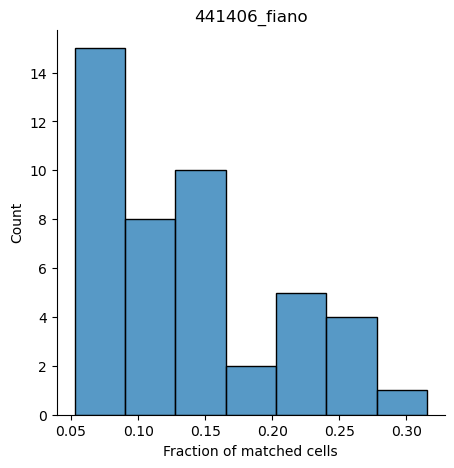

In [41]:
import seaborn as sns
plt.figure(figsize=(5,5))
plt.title(f'{animal}')
sns.histplot(matched_fraction);
sns.despine()
plt.xlabel('Fraction of matched cells')
plt.savefig(f'/ceph/imaging1/davide/2p_data/images/matched_frac_eq_lum_{animal}.png')

In [52]:
import yaml 

In [53]:
filename = '/ceph/imaging1/arie/preprocess_params/default_parameters.yml'

In [55]:
# Program to convert yaml file to dictionary
import yaml
# opening a file
with open(filename, 'r') as stream:
    try:
    # Converts yaml document to python object
        d=yaml.safe_load(stream)

    # Printing dictionary
        print(d)
    except yaml.YAMLError as e:
        print(e)

{'cnmf_params': {'K': 6, 'cnn_lowest': 0.9, 'decay_time': 0.4, 'fr': 30, 'gSig': [6, 6], 'merge_thr': 0.85, 'method_init': 'greedy_roi', 'min_SNR': 3.0, 'min_SNR_reject': 3.0, 'min_cnn_thr': 0.9, 'nb': 2, 'p': 1, 'rf': 20, 'rval_thr': 0.9, 'ssub': 1, 'stride': 12, 'tsub': 1, 'use_cnn': True}, 'compute_flags': {'correct_luminance': False, 'deconvolve': True, 'detrend_df_f': True, 'n_processes': 5, 'refit_cnmf': True}, 'cropping_params': {'cropping_limits': [10, -10, 10, -10], 'cropping_times': [0, -1]}, 'df_f_params': {'frames_window': 250, 'quantileMin': 8}, 'mc_params': {'border_nan': 'copy', 'gSig_filt': None, 'max_deviation_rigid': 5, 'max_shifts': [20, 20], 'num_frames_split': 300, 'overlaps': [24, 24], 'pw_rigid': True, 'strides': [48, 48], 'use_cuda': True}, 'metrics_params': ['mean_image', 'frame_average', 'corr_image']}
